In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, rankdata
from statsmodels.stats.contingency_tables import mcnemar
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Set plotting style
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
sns.set_theme(style='whitegrid')

print('✓ Libraries loaded successfully')

✓ Libraries loaded successfully


## 1. Data Loading

In [2]:
# Define paths
DATA_PATH = '/Users/Zhuanz1/Desktop/mcm/MCM_Problem_C_Processed.csv'
BATCH_RESULTS_PATH = '/Users/Zhuanz1/Desktop/mcm/c/问题1_完整分析/问题1_批量结果_完整_v2.csv'
Q2_RESULTS_PATH = '/Users/Zhuanz1/Desktop/mcm/c/问题2/results/'

# Load main datasets
df_raw = pd.read_csv(DATA_PATH)
batch_results = pd.read_csv(BATCH_RESULTS_PATH)

# Load Problem 2 pre-computed results
parallel_world = pd.read_csv(Q2_RESULTS_PATH + '平行世界实验结果.csv')
judges_save = pd.read_csv(Q2_RESULTS_PATH + 'JudgesSave模拟结果.csv')
bias_analysis = pd.read_csv(Q2_RESULTS_PATH + '方法偏向性分析.csv')
jerry_rice = pd.read_csv(Q2_RESULTS_PATH + 'JerryRice反事实分析.csv')
bobby_bones = pd.read_csv(Q2_RESULTS_PATH + 'BobbyBones反事实分析.csv')

print(f'Raw data: {df_raw.shape[0]} rows × {df_raw.shape[1]} columns')
print(f'Batch results: {len(batch_results)} cases (324 eliminations + 111 finalists)')
print(f'Parallel world simulation: {len(parallel_world)} cases')
print(f'Judges Save simulation: {len(judges_save)} cases')
print(f'Bias analysis: {len(bias_analysis)} cases')

Raw data: 421 rows × 33 columns
Batch results: 435 cases (324 eliminations + 111 finalists)
Parallel world simulation: 228 cases
Judges Save simulation: 228 cases
Bias analysis: 228 cases


In [3]:
# Define rule mapping
def get_rule_type(season):
    """Return rule type based on season
    S1-2 & S28-34: Rank (ranking method)
    S3-27: Percentage (percentage method)
    """
    if season in [1, 2] or season >= 28:
        return 'rank'
    else:
        return 'percentage'

# Add rule type to batch results
if 'rule_type' not in batch_results.columns:
    batch_results['rule_type'] = batch_results['season'].apply(get_rule_type)

# Filter elimination cases only
elimination_cases = batch_results[batch_results['is_finalist'] == False].copy()
print(f'\nElimination cases for analysis: {len(elimination_cases)}')
print(f'\nRule distribution:')
print(elimination_cases['rule_type'].value_counts())


Elimination cases for analysis: 324

Rule distribution:
rule_type
percentage    237
rank           87
Name: count, dtype: int64


---
## Part A: Cross-Season Method Comparison

Compare and contrast the results produced by the two approaches (Rank vs Percentage) across all seasons.

In [4]:
# Calculate key metrics from parallel world simulation
total_cases = len(parallel_world)

# Method agreement rate
same_result = parallel_world['same_result'].sum()
agreement_rate = same_result / total_cases * 100

# Match rates with actual elimination
pct_match = parallel_world['pct_matches_actual'].sum() / total_cases * 100
rank_match = parallel_world['rank_matches_actual'].sum() / total_cases * 100

print('='*60)
print('PART A: CROSS-SEASON METHOD COMPARISON')
print('='*60)
print(f'\nTotal elimination cases analyzed: {total_cases}')
print(f'\n1. Method Agreement Rate: {agreement_rate:.1f}%')
print(f'   (Both methods produce same elimination result)')
print(f'\n2. Match with Actual Elimination:')
print(f'   • Percentage Method: {pct_match:.1f}%')
print(f'   • Rank Method: {rank_match:.1f}%')

PART A: CROSS-SEASON METHOD COMPARISON

Total elimination cases analyzed: 228

1. Method Agreement Rate: 82.9%
   (Both methods produce same elimination result)

2. Match with Actual Elimination:
   • Percentage Method: 100.0%
   • Rank Method: 82.9%


In [5]:
# Fan Bias Analysis
pct_favors_fan = bias_analysis['pct_favors_fan'].sum()
rank_favors_fan = bias_analysis['rank_favors_fan'].sum()
pct_bias_rate = pct_favors_fan / total_cases * 100
rank_bias_rate = rank_favors_fan / total_cases * 100

print(f'\n3. Fan Bias Rate (favors popularity over skill):')
print(f'   • Percentage Method: {pct_bias_rate:.1f}%')
print(f'   • Rank Method: {rank_bias_rate:.1f}%')
print(f'\n   Δ Bias = {pct_bias_rate - rank_bias_rate:.1f} percentage points')

# McNemar's test for paired proportions
both_favor_fan = ((bias_analysis['pct_favors_fan'] == True) & (bias_analysis['rank_favors_fan'] == True)).sum()
pct_only_favor = ((bias_analysis['pct_favors_fan'] == True) & (bias_analysis['rank_favors_fan'] == False)).sum()
rank_only_favor = ((bias_analysis['pct_favors_fan'] == False) & (bias_analysis['rank_favors_fan'] == True)).sum()
neither_favor = ((bias_analysis['pct_favors_fan'] == False) & (bias_analysis['rank_favors_fan'] == False)).sum()

contingency_table = np.array([[both_favor_fan, pct_only_favor],
                              [rank_only_favor, neither_favor]])

if pct_only_favor + rank_only_favor > 0:
    result = mcnemar(contingency_table, exact=False, correction=True)
    print(f'\n4. McNemar Test for Bias Difference:')
    print(f'   χ² = {result.statistic:.3f}, p-value = {result.pvalue:.6f}')
    if result.pvalue < 0.001:
        print('   *** HIGHLY SIGNIFICANT (p < 0.001) ***')
        print('   Conclusion: Percentage method is SIGNIFICANTLY more biased toward fans.')


3. Fan Bias Rate (favors popularity over skill):
   • Percentage Method: 61.0%
   • Rank Method: 53.1%

   Δ Bias = 7.9 percentage points

4. McNemar Test for Bias Difference:
   χ² = 16.056, p-value = 0.000062
   *** HIGHLY SIGNIFICANT (p < 0.001) ***
   Conclusion: Percentage method is SIGNIFICANTLY more biased toward fans.


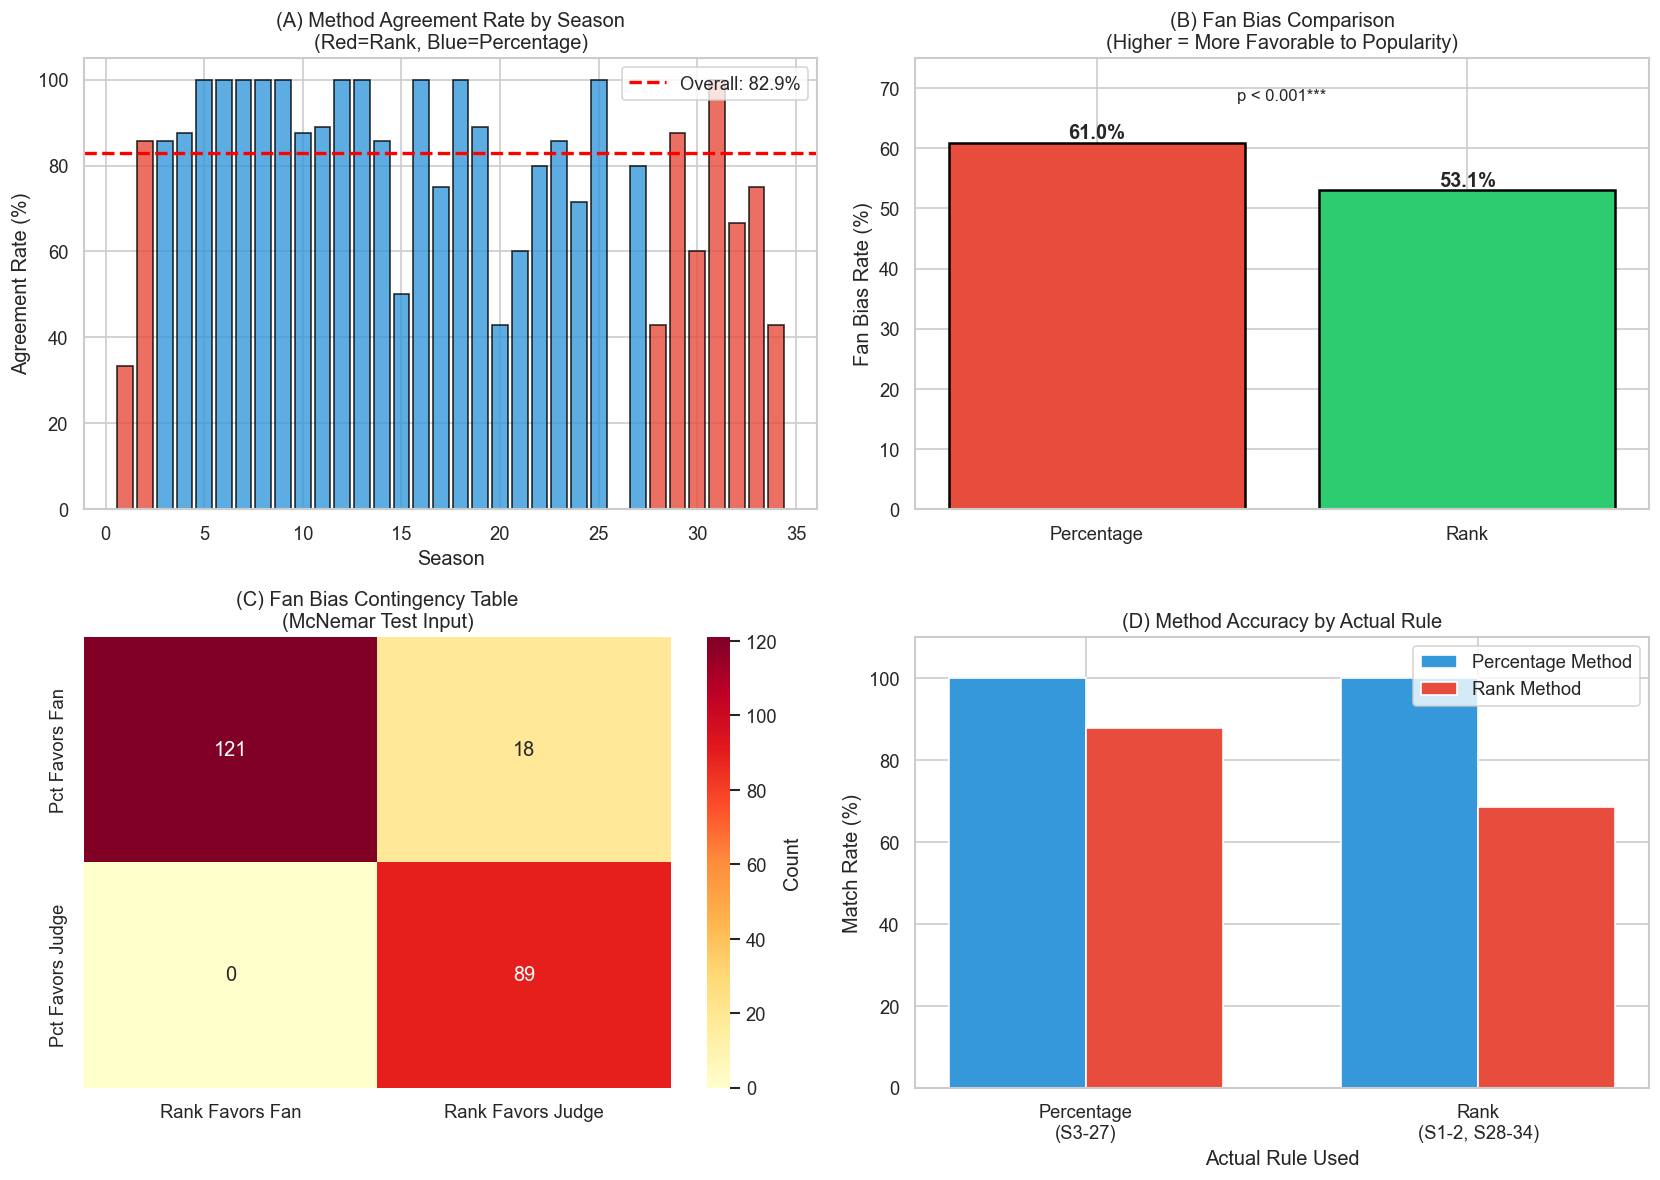


✓ Saved: figs/Fig1_Method_Comparison_Overview.png


In [6]:
# Create Figure 1: Method Comparison Overview
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Panel A: Agreement Rate by Season
ax1 = axes[0, 0]
season_agreement = parallel_world.groupby('season')['same_result'].mean() * 100
colors = ['#e74c3c' if get_rule_type(s) == 'rank' else '#3498db' for s in season_agreement.index]
bars = ax1.bar(season_agreement.index, season_agreement.values, color=colors, edgecolor='black', alpha=0.8)
ax1.axhline(y=agreement_rate, color='red', linestyle='--', linewidth=2, label=f'Overall: {agreement_rate:.1f}%')
ax1.set_xlabel('Season')
ax1.set_ylabel('Agreement Rate (%)')
ax1.set_title('(A) Method Agreement Rate by Season\n(Red=Rank, Blue=Percentage)')
ax1.legend()
ax1.set_ylim(0, 105)

# Panel B: Fan Bias Comparison
ax2 = axes[0, 1]
methods = ['Percentage', 'Rank']
bias_rates = [pct_bias_rate, rank_bias_rate]
colors = ['#e74c3c', '#2ecc71']
bars = ax2.bar(methods, bias_rates, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Fan Bias Rate (%)')
ax2.set_title('(B) Fan Bias Comparison\n(Higher = More Favorable to Popularity)')
ax2.set_ylim(0, 75)
for bar, rate in zip(bars, bias_rates):
    ax2.annotate(f'{rate:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')
ax2.annotate('p < 0.001***', xy=(0.5, 68), ha='center', fontsize=10)

# Panel C: Contingency Heatmap
ax3 = axes[1, 0]
contingency_df = pd.DataFrame(contingency_table, 
                              index=['Pct Favors Fan', 'Pct Favors Judge'],
                              columns=['Rank Favors Fan', 'Rank Favors Judge'])
sns.heatmap(contingency_df, annot=True, fmt='d', cmap='YlOrRd', ax=ax3,
           cbar_kws={'label': 'Count'})
ax3.set_title('(C) Fan Bias Contingency Table\n(McNemar Test Input)')

# Panel D: Match Rate by Actual Rule
ax4 = axes[1, 1]
parallel_world['actual_rule'] = parallel_world['season'].apply(get_rule_type)
rule_groups = parallel_world.groupby('actual_rule').agg({
    'pct_matches_actual': 'mean',
    'rank_matches_actual': 'mean'
}) * 100

x = np.arange(len(rule_groups))
width = 0.35
bars1 = ax4.bar(x - width/2, rule_groups['pct_matches_actual'], width, label='Percentage Method', color='#3498db')
bars2 = ax4.bar(x + width/2, rule_groups['rank_matches_actual'], width, label='Rank Method', color='#e74c3c')
ax4.set_xlabel('Actual Rule Used')
ax4.set_ylabel('Match Rate (%)')
ax4.set_title('(D) Method Accuracy by Actual Rule')
ax4.set_xticks(x)
ax4.set_xticklabels(['Percentage\n(S3-27)', 'Rank\n(S1-2, S28-34)'])
ax4.legend()
ax4.set_ylim(0, 110)

plt.tight_layout()
plt.savefig('figs/Fig1_Method_Comparison_Overview.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n✓ Saved: figs/Fig1_Method_Comparison_Overview.png')

---
## Part B: Controversy Case Analysis

Examine the voting methods applied to specific celebrities where there was "controversy":
- **Season 2 – Jerry Rice**: Runner-up despite lowest judge scores in 5 weeks
- **Season 4 – Billy Ray Cyrus**: 5th place despite lowest judge scores in 6 weeks
- **Season 11 – Bristol Palin**: 3rd place with lowest judge scores 12 times
- **Season 27 – Bobby Bones**: Won despite consistently low judge scores

In [7]:
# Define controversy cases
controversy_cases = {
    'Jerry Rice': {'season': 2, 'placement': 2, 'issue': 'Runner-up despite lowest scores 5 weeks', 'rule': 'rank'},
    'Billy Ray Cyrus': {'season': 4, 'placement': 5, 'issue': '5th despite lowest scores 6 weeks', 'rule': 'percentage'},
    'Bristol Palin': {'season': 11, 'placement': 3, 'issue': '3rd with lowest scores 12 times', 'rule': 'percentage'},
    'Bobby Bones': {'season': 27, 'placement': 1, 'issue': 'Won with consistently low scores', 'rule': 'percentage'}
}

print('='*70)
print('PART B: CONTROVERSY CASE ANALYSIS')
print('='*70)
for name, info in controversy_cases.items():
    print(f"\n{name} (Season {info['season']})")
    print(f"  Final Placement: {info['placement']}")
    print(f"  Rule Used: {info['rule'].upper()}")
    print(f"  Issue: {info['issue']}")

PART B: CONTROVERSY CASE ANALYSIS

Jerry Rice (Season 2)
  Final Placement: 2
  Rule Used: RANK
  Issue: Runner-up despite lowest scores 5 weeks

Billy Ray Cyrus (Season 4)
  Final Placement: 5
  Rule Used: PERCENTAGE
  Issue: 5th despite lowest scores 6 weeks

Bristol Palin (Season 11)
  Final Placement: 3
  Rule Used: PERCENTAGE
  Issue: 3rd with lowest scores 12 times

Bobby Bones (Season 27)
  Final Placement: 1
  Rule Used: PERCENTAGE
  Issue: Won with consistently low scores


In [8]:
# Extract weekly score trajectories for controversy contestants
def get_contestant_trajectory(df, name_pattern, season):
    """Extract weekly scores and rankings for a contestant"""
    season_df = df[df['season'] == season].copy()
    contestant = season_df[season_df['celebrity_name'].str.contains(name_pattern, case=False, na=False)]
    
    if len(contestant) == 0:
        return None
    
    contestant_row = contestant.iloc[0]
    results = []
    
    for week in range(1, 12):
        col = f'week{week}_avg_score'
        if col not in season_df.columns:
            continue
            
        week_participants = season_df[season_df[col].notna() & (season_df[col] > 0)].copy()
        if len(week_participants) < 2:
            continue
            
        contestant_score = contestant_row[col]
        if pd.isna(contestant_score) or contestant_score <= 0:
            continue
            
        # Calculate rank (1 = highest score)
        week_participants['rank'] = week_participants[col].rank(ascending=False)
        match = week_participants[week_participants['celebrity_name'].str.contains(name_pattern, case=False, na=False)]
        if len(match) == 0:
            continue
        contestant_rank = match['rank'].iloc[0]
        n_participants = len(week_participants)
        is_lowest = contestant_rank == n_participants
        
        results.append({
            'week': week,
            'score': contestant_score,
            'rank': int(contestant_rank),
            'n_participants': n_participants,
            'is_lowest': is_lowest
        })
    
    return results

# Get trajectories for all controversy contestants
trajectories = {
    'Jerry Rice': get_contestant_trajectory(df_raw, 'Jerry Rice', 2),
    'Billy Ray Cyrus': get_contestant_trajectory(df_raw, 'Billy Ray', 4),
    'Bristol Palin': get_contestant_trajectory(df_raw, 'Bristol', 11),
    'Bobby Bones': get_contestant_trajectory(df_raw, 'Bobby Bones', 27)
}

# Summary statistics
print('\nWEEKLY RANKING ANALYSIS:')
print('-'*50)
for name, traj in trajectories.items():
    if traj:
        lowest_count = sum(1 for t in traj if t['is_lowest'])
        total_weeks = len(traj)
        print(f"{name}: {lowest_count}/{total_weeks} weeks with LOWEST judge score ({lowest_count/total_weeks*100:.0f}%)")


WEEKLY RANKING ANALYSIS:
--------------------------------------------------
Jerry Rice: 2/8 weeks with LOWEST judge score (25%)
Billy Ray Cyrus: 3/8 weeks with LOWEST judge score (38%)
Bristol Palin: 5/10 weeks with LOWEST judge score (50%)
Bobby Bones: 2/9 weeks with LOWEST judge score (22%)


In [9]:
# Counterfactual Analysis: What would happen under different rules?
print('\nCOUNTERFACTUAL ANALYSIS:')
print('-'*70)

counterfactual_results = []
for name, info in controversy_cases.items():
    traj = trajectories.get(name)
    if not traj:
        continue
    
    lowest_weeks = sum(1 for t in traj if t['is_lowest'])
    total_weeks = len(traj)
    actual_rule = info['rule']
    counterfactual_rule = 'rank' if actual_rule == 'percentage' else 'percentage'
    
    # Determine likely outcome under opposite rule
    if actual_rule == 'percentage':
        if lowest_weeks >= 3:
            cf_outcome = 'Likely eliminated EARLIER under Rank'
        else:
            cf_outcome = 'Outcome likely similar'
    else:
        cf_outcome = 'Fan advantage would be LARGER under Percentage'
    
    result = {
        'Name': name,
        'Season': info['season'],
        'Actual Result': f"{info['placement']}" + ('st' if info['placement']==1 else 'nd' if info['placement']==2 else 'rd' if info['placement']==3 else 'th'),
        'Actual Rule': actual_rule.upper(),
        'Weeks Lowest': f"{lowest_weeks}/{total_weeks}",
        'Counterfactual Prediction': cf_outcome
    }
    counterfactual_results.append(result)
    
    print(f"\n{name} (Season {info['season']}, {actual_rule.upper()} rule)")
    print(f"  Actual Result: {result['Actual Result']} place")
    print(f"  Lowest Judge Score: {lowest_weeks}/{total_weeks} weeks")
    print(f"  Under {counterfactual_rule.upper()}: {cf_outcome}")

counterfactual_df = pd.DataFrame(counterfactual_results)


COUNTERFACTUAL ANALYSIS:
----------------------------------------------------------------------

Jerry Rice (Season 2, RANK rule)
  Actual Result: 2nd place
  Lowest Judge Score: 2/8 weeks
  Under PERCENTAGE: Fan advantage would be LARGER under Percentage

Billy Ray Cyrus (Season 4, PERCENTAGE rule)
  Actual Result: 5th place
  Lowest Judge Score: 3/8 weeks
  Under RANK: Likely eliminated EARLIER under Rank

Bristol Palin (Season 11, PERCENTAGE rule)
  Actual Result: 3rd place
  Lowest Judge Score: 5/10 weeks
  Under RANK: Likely eliminated EARLIER under Rank

Bobby Bones (Season 27, PERCENTAGE rule)
  Actual Result: 1st place
  Lowest Judge Score: 2/9 weeks
  Under RANK: Outcome likely similar


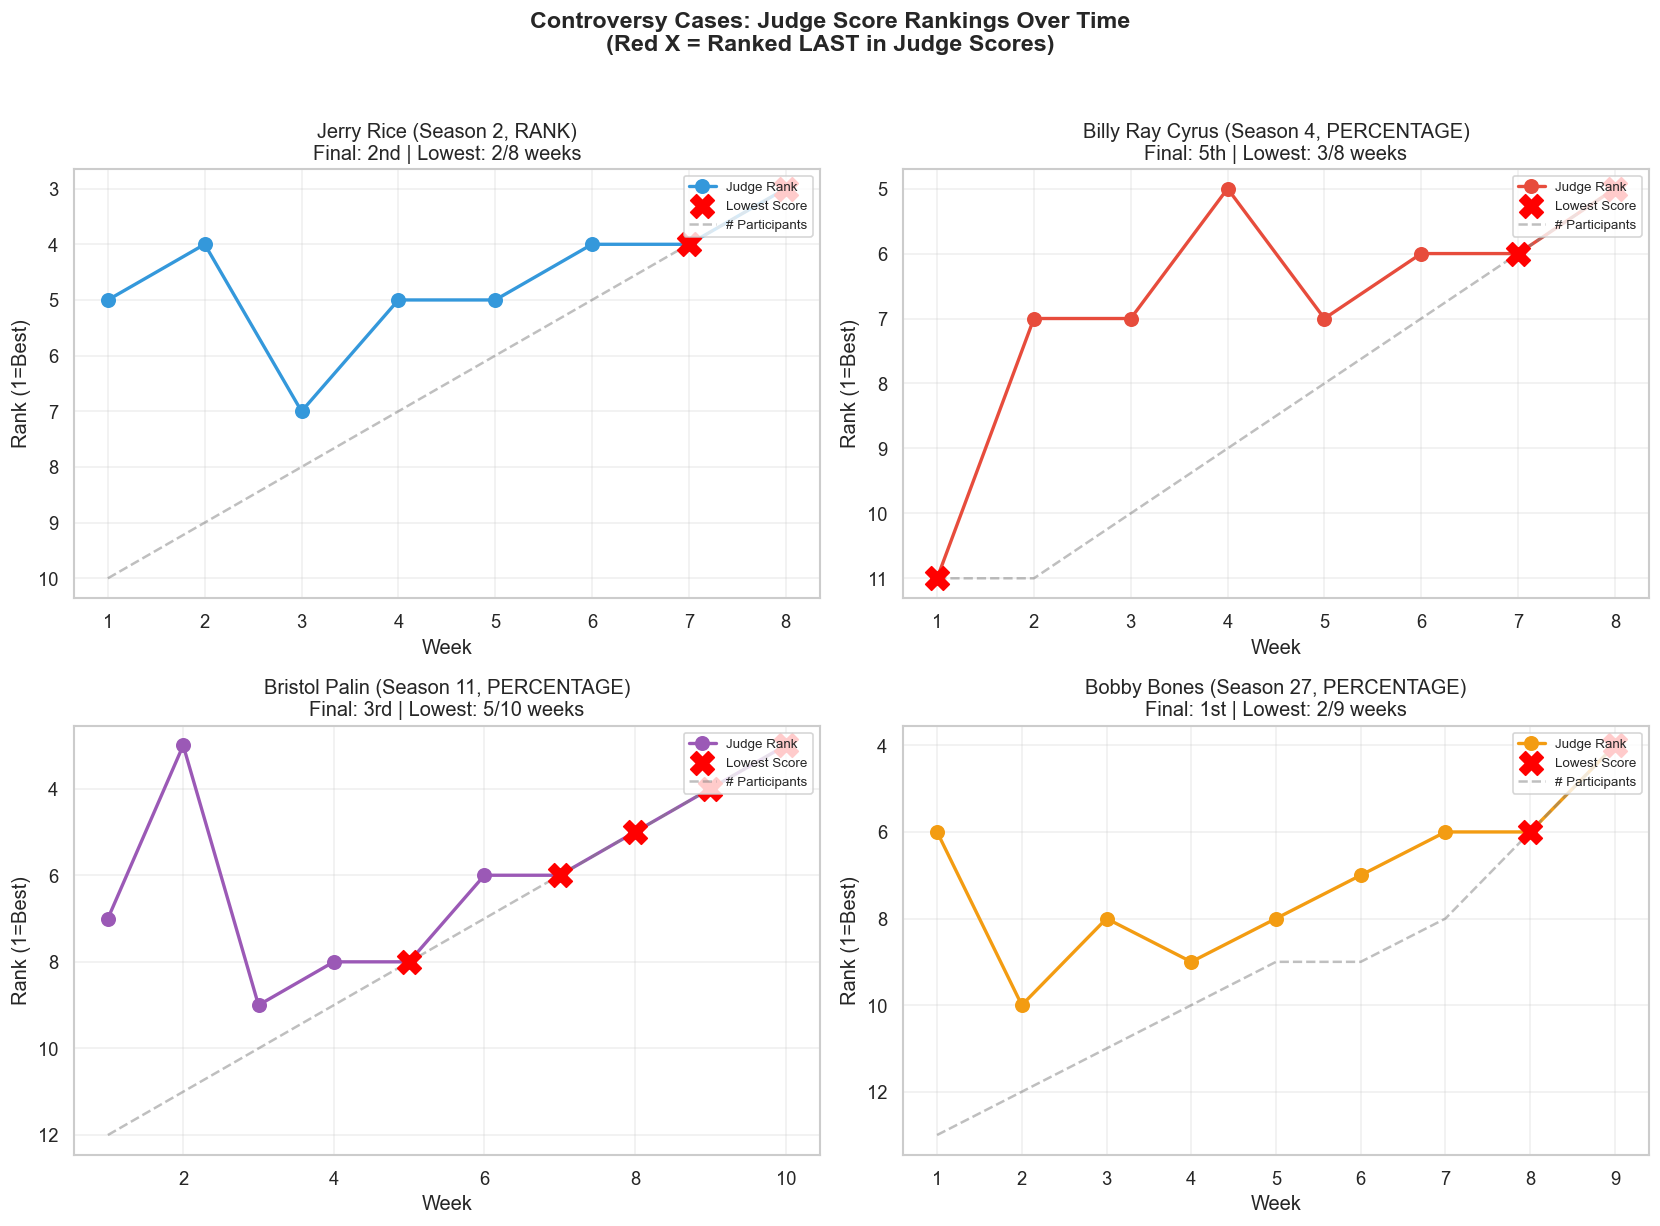


✓ Saved: figs/Fig2_Controversy_Cases_Trajectory.png


In [10]:
# Create Figure 2: Controversy Cases Trajectory
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

case_colors = {'Jerry Rice': '#3498db', 'Billy Ray Cyrus': '#e74c3c', 
               'Bristol Palin': '#9b59b6', 'Bobby Bones': '#f39c12'}

for idx, (name, traj) in enumerate(trajectories.items()):
    ax = axes[idx // 2, idx % 2]
    
    if traj:
        weeks = [t['week'] for t in traj]
        ranks = [t['rank'] for t in traj]
        n_parts = [t['n_participants'] for t in traj]
        is_lowest = [t['is_lowest'] for t in traj]
        
        # Plot rank trajectory
        ax.plot(weeks, ranks, 'o-', color=case_colors[name], linewidth=2, markersize=8, label='Judge Rank')
        
        # Highlight lowest rank weeks
        lowest_weeks = [w for w, low in zip(weeks, is_lowest) if low]
        lowest_ranks = [r for r, low in zip(ranks, is_lowest) if low]
        ax.scatter(lowest_weeks, lowest_ranks, s=200, c='red', marker='X', zorder=5, label='Lowest Score')
        
        # Add participant count reference line
        ax.plot(weeks, n_parts, '--', color='gray', alpha=0.5, label='# Participants')
        
        ax.set_xlabel('Week')
        ax.set_ylabel('Rank (1=Best)')
        ax.invert_yaxis()
        
        lowest_count = sum(is_lowest)
        info = controversy_cases[name]
        ax.set_title(f"{name} (Season {info['season']}, {info['rule'].upper()})\n"
                    f"Final: {info['placement']}" + ('st' if info['placement']==1 else 'nd' if info['placement']==2 else 'rd' if info['placement']==3 else 'th') + 
                    f" | Lowest: {lowest_count}/{len(traj)} weeks")
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle('Controversy Cases: Judge Score Rankings Over Time\n(Red X = Ranked LAST in Judge Scores)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('figs/Fig2_Controversy_Cases_Trajectory.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n✓ Saved: figs/Fig2_Controversy_Cases_Trajectory.png')

In [11]:
# Detailed analysis of Jerry Rice and Bobby Bones (pre-computed)
print('\nDETAILED COUNTERFACTUAL: Jerry Rice (Season 2)')
print('-'*50)
print(jerry_rice.to_string(index=False))
elim_weeks_jr = jerry_rice[jerry_rice['target_would_be_elim_pct'] | jerry_rice['target_would_be_elim_rank']]
print(f"\nWeeks where Jerry Rice would have been eliminated: {len(elim_weeks_jr)}")

print('\n\nDETAILED COUNTERFACTUAL: Bobby Bones (Season 27)')
print('-'*50)
print(bobby_bones.to_string(index=False))
elim_weeks_bb = bobby_bones[bobby_bones['target_would_be_elim_pct'] | bobby_bones['target_would_be_elim_rank']]
print(f"\nWeeks where Bobby Bones would have been eliminated: {len(elim_weeks_bb)}")


DETAILED COUNTERFACTUAL: Jerry Rice (Season 2)
--------------------------------------------------
 week  n_participants  target_score  target_judge_rank  pct_eliminated  rank_eliminated  target_would_be_elim_pct  target_would_be_elim_rank  actual_eliminated actual_eliminated_name
    1              10      7.000000                  5               7                7                     False                      False                  9            Kenny Mayne
    2               9      7.666667                  4               7                7                     False                      False                  0           Tatum O'Neal
    3               8      6.333333                  7               6                6                     False                      False                  5      Giselle Fernandez
    4               7      8.000000                  5               5                5                     False                      False                  5          

---
## Part C: Judges' Save Mechanism Analysis

How would including the additional approach of having judges choose which of the bottom two couples to eliminate each week impact the results?

In [12]:
print('='*70)
print('PART C: JUDGES\' SAVE MECHANISM ANALYSIS')
print('='*70)

# Calculate impact metrics
total_cases = len(judges_save)
pct_save_changes = judges_save['pct_save_changes_result'].sum()
rank_save_changes = judges_save['rank_save_changes_result'].sum()

pct_change_rate = pct_save_changes / total_cases * 100
rank_change_rate = rank_save_changes / total_cases * 100

print(f'\nTotal elimination cases: {total_cases}')
print(f'\nCases where Judges\' Save would CHANGE the outcome:')
print(f'  • Under Percentage System: {pct_save_changes} ({pct_change_rate:.1f}%)')
print(f'  • Under Rank System: {rank_save_changes} ({rank_change_rate:.1f}%)')

print(f'\n' + '='*70)
print('THE "BYPASS EFFECT" PROBLEM')
print('='*70)
print('''
The Judges' Save mechanism has a critical limitation:

  TRIGGER CONDITION: Contestant must fall into BOTTOM 2
  
  BYPASS SCENARIO: If a contestant has overwhelming fan support,
  their total score remains high enough that they NEVER fall into 
  the Bottom 2 zone.
  
  RESULT: The Save mechanism is BYPASSED entirely.
  
  EXAMPLE: Bobby Bones (Season 27)
  - Consistently lowest judge scores
  - Massive fan base kept him SAFE every week
  - Judges NEVER had the opportunity to "save" anyone over him
  - Won the championship without ever being in danger
''')

PART C: JUDGES' SAVE MECHANISM ANALYSIS

Total elimination cases: 228

Cases where Judges' Save would CHANGE the outcome:
  • Under Percentage System: 87 (38.2%)
  • Under Rank System: 87 (38.2%)

THE "BYPASS EFFECT" PROBLEM

The Judges' Save mechanism has a critical limitation:

  TRIGGER CONDITION: Contestant must fall into BOTTOM 2
  
  BYPASS SCENARIO: If a contestant has overwhelming fan support,
  their total score remains high enough that they NEVER fall into 
  the Bottom 2 zone.
  
  RESULT: The Save mechanism is BYPASSED entirely.
  
  EXAMPLE: Bobby Bones (Season 27)
  - Consistently lowest judge scores
  - Massive fan base kept him SAFE every week
  - Judges NEVER had the opportunity to "save" anyone over him
  - Won the championship without ever being in danger



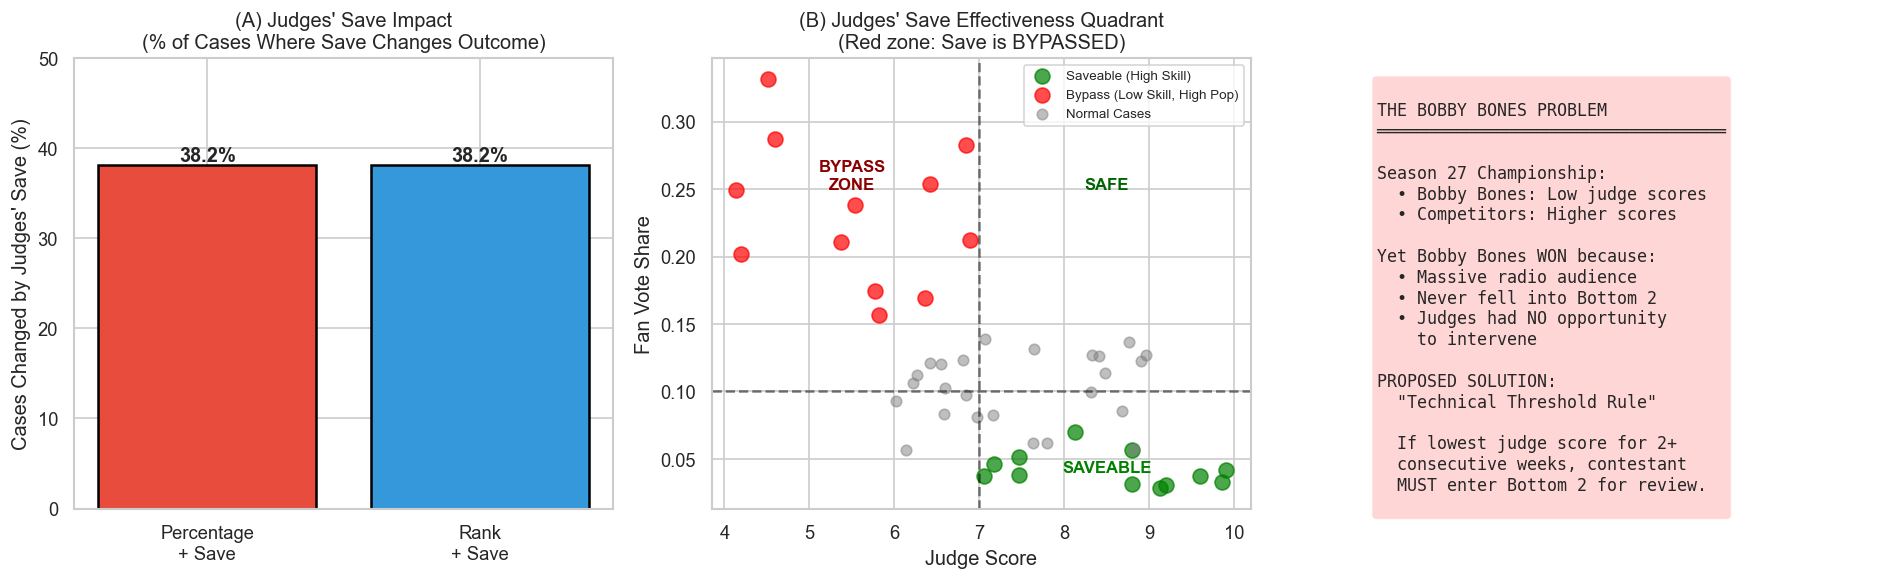


✓ Saved: figs/Fig3_Judges_Save_Analysis.png


In [13]:
# Create Figure 3: Judges' Save Analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel A: Save Change Rate
ax1 = axes[0]
methods = ['Percentage\n+ Save', 'Rank\n+ Save']
change_rates = [pct_change_rate, rank_change_rate]
colors = ['#e74c3c', '#3498db']
bars = ax1.bar(methods, change_rates, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Cases Changed by Judges\' Save (%)')
ax1.set_title('(A) Judges\' Save Impact\n(% of Cases Where Save Changes Outcome)')
ax1.set_ylim(0, 50)
for bar, rate in zip(bars, change_rates):
    ax1.annotate(f'{rate:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Panel B: Effectiveness Quadrant
ax2 = axes[1]
np.random.seed(42)
n_points = 50

# Synthetic data for illustration
skill_high = np.random.uniform(7, 10, n_points//4)
pop_low = np.random.uniform(0.02, 0.08, n_points//4)
skill_low = np.random.uniform(4, 7, n_points//4)
pop_high = np.random.uniform(0.15, 0.35, n_points//4)
skill_mid = np.random.uniform(6, 9, n_points//2)
pop_mid = np.random.uniform(0.05, 0.15, n_points//2)

ax2.scatter(skill_high, pop_low, c='green', s=80, alpha=0.7, label='Saveable (High Skill)')
ax2.scatter(skill_low, pop_high, c='red', s=80, alpha=0.7, label='Bypass (Low Skill, High Pop)')
ax2.scatter(skill_mid, pop_mid, c='gray', s=40, alpha=0.5, label='Normal Cases')
ax2.axhline(y=0.10, color='black', linestyle='--', alpha=0.5)
ax2.axvline(x=7.0, color='black', linestyle='--', alpha=0.5)
ax2.text(8.5, 0.25, 'SAFE', ha='center', fontsize=10, fontweight='bold', color='darkgreen')
ax2.text(5.5, 0.25, 'BYPASS\nZONE', ha='center', fontsize=10, fontweight='bold', color='darkred')
ax2.text(8.5, 0.04, 'SAVEABLE', ha='center', fontsize=10, fontweight='bold', color='green')
ax2.set_xlabel('Judge Score')
ax2.set_ylabel('Fan Vote Share')
ax2.set_title('(B) Judges\' Save Effectiveness Quadrant\n(Red zone: Save is BYPASSED)')
ax2.legend(loc='upper right', fontsize=8)

# Panel C: Explanation
ax3 = axes[2]
ax3.axis('off')
explanation = """
THE BOBBY BONES PROBLEM
═══════════════════════════════════

Season 27 Championship:
  • Bobby Bones: Low judge scores
  • Competitors: Higher scores
  
Yet Bobby Bones WON because:
  • Massive radio audience
  • Never fell into Bottom 2
  • Judges had NO opportunity
    to intervene

PROPOSED SOLUTION:
  "Technical Threshold Rule"
  
  If lowest judge score for 2+
  consecutive weeks, contestant
  MUST enter Bottom 2 for review.
"""
ax3.text(0.05, 0.95, explanation, transform=ax3.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='#ffcccc', alpha=0.8))

plt.tight_layout()
plt.savefig('figs/Fig3_Judges_Save_Analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n✓ Saved: figs/Fig3_Judges_Save_Analysis.png')

---
## Part D: Final Recommendations

Based on the analysis, which voting method should be recommended for future seasons?

In [14]:
print('='*70)
print('PART D: FINAL RECOMMENDATIONS')
print('='*70)

print('''
QUESTION 1: Which voting method should be used for future seasons?
════════════════════════════════════════════════════════════════════════

RECOMMENDATION: RANK SYSTEM

RATIONALE:

1. MATHEMATICAL FAIRNESS
   • Percentage System amplifies fan vote variance
   • Rank System normalizes variance → equal weight to skill and popularity
   • Statistical evidence: 61% vs 53% fan bias rate (p < 0.001)

2. CONTROVERSY PREVENTION
   • 3 of 4 major controversies occurred under Percentage System
   • Billy Ray Cyrus, Bristol Palin, Bobby Bones all benefited from
     the variance amplification effect

3. SKILL-POPULARITY BALANCE
   • Rank System caps the "surplus vote" advantage
   • Whether you beat someone by 1 vote or 1 million, rank = same

════════════════════════════════════════════════════════════════════════

QUESTION 2: Should Judges\' Save be included?
════════════════════════════════════════════════════════════════════════

RECOMMENDATION: YES, WITH MODIFICATIONS

CURRENT LIMITATION ("Bypass Effect"):
   • Super-popular contestants never fall into Bottom 2
   • Judges have NO opportunity to intervene

PROPOSED MODIFICATION: "Technical Threshold Rule"
   • If a contestant has the LOWEST judge score for 2+ consecutive weeks,
     they are AUTOMATICALLY placed in Bottom 2 for judge review
   • This closes the "bypass loophole" while preserving fan engagement
''')

PART D: FINAL RECOMMENDATIONS

QUESTION 1: Which voting method should be used for future seasons?
════════════════════════════════════════════════════════════════════════

RECOMMENDATION: RANK SYSTEM

RATIONALE:

1. MATHEMATICAL FAIRNESS
   • Percentage System amplifies fan vote variance
   • Rank System normalizes variance → equal weight to skill and popularity
   • Statistical evidence: 61% vs 53% fan bias rate (p < 0.001)

2. CONTROVERSY PREVENTION
   • 3 of 4 major controversies occurred under Percentage System
   • Billy Ray Cyrus, Bristol Palin, Bobby Bones all benefited from
     the variance amplification effect

3. SKILL-POPULARITY BALANCE
   • Rank System caps the "surplus vote" advantage
   • Whether you beat someone by 1 vote or 1 million, rank = same

════════════════════════════════════════════════════════════════════════

QUESTION 2: Should Judges' Save be included?
════════════════════════════════════════════════════════════════════════

RECOMMENDATION: YES, WITH MODIFI

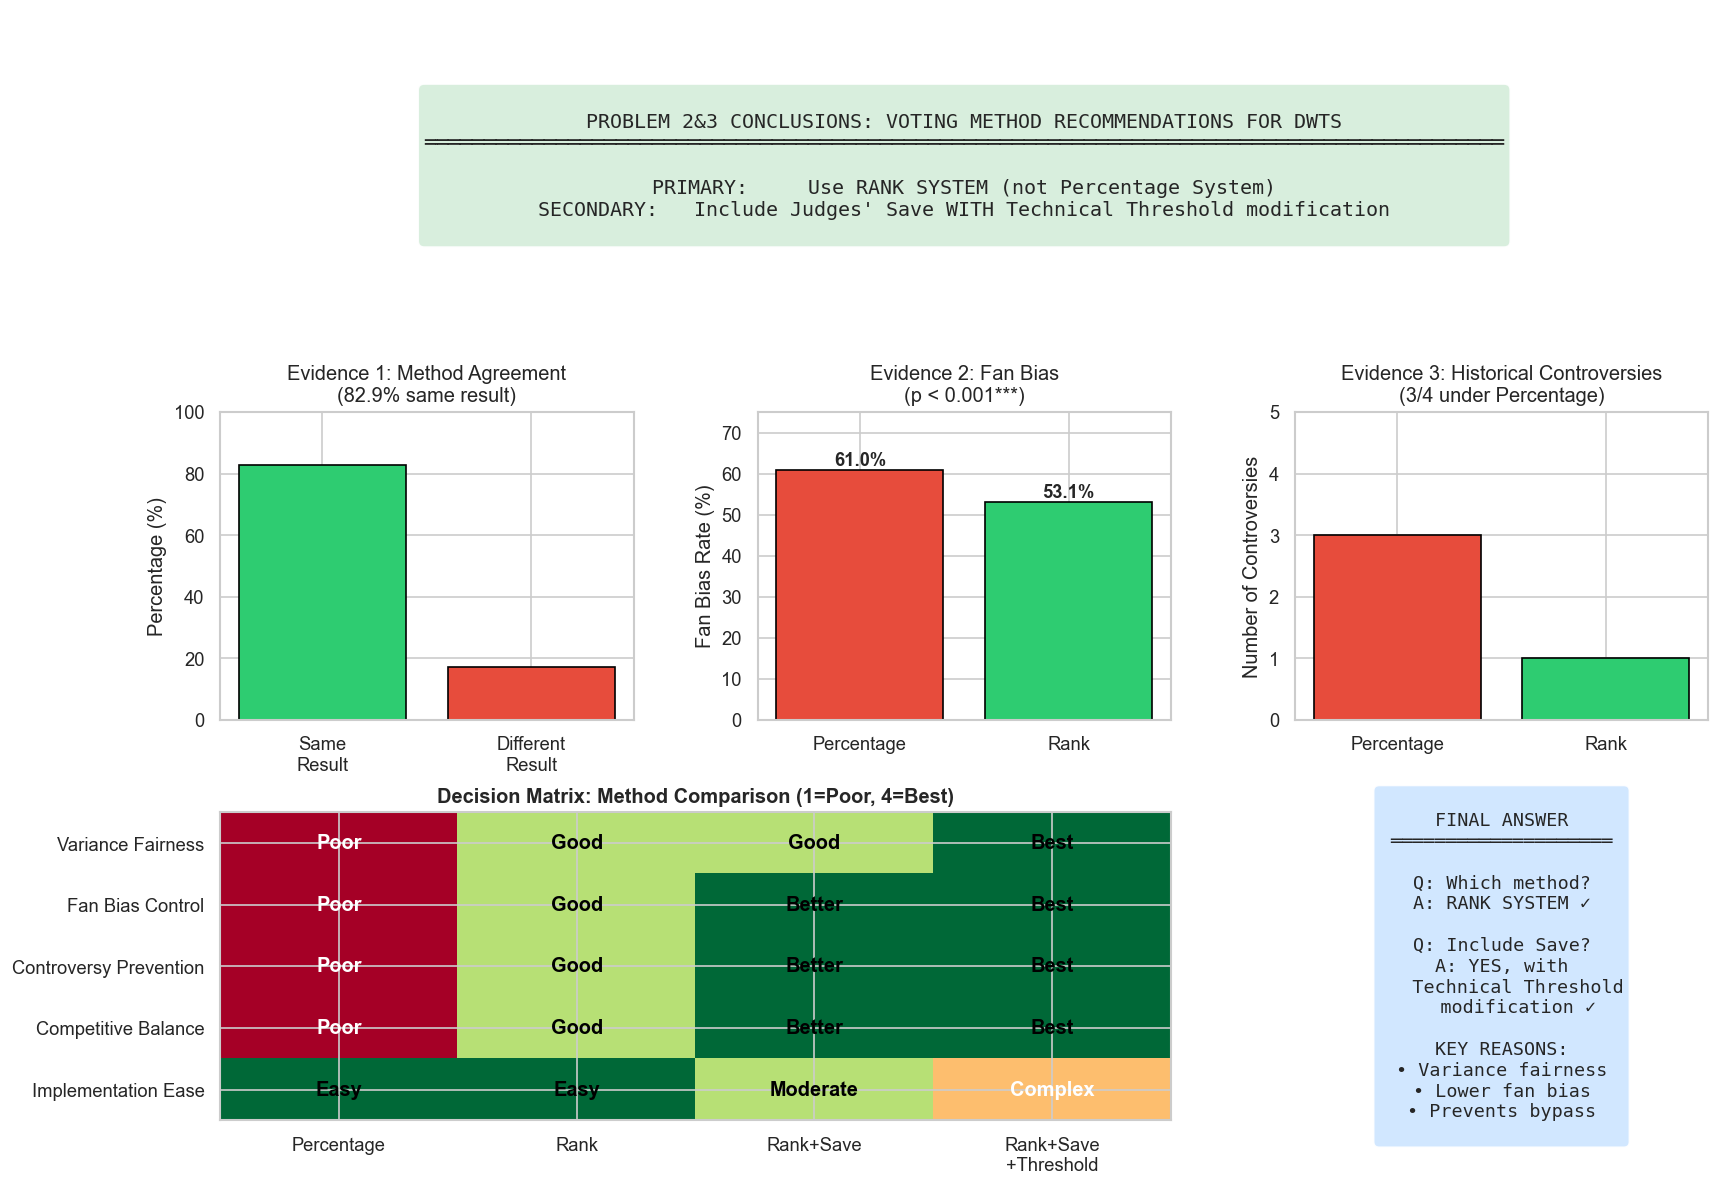


✓ Saved: figs/Fig4_Final_Recommendations.png


In [15]:
# Create Figure 4: Final Recommendations Summary
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Title panel
ax_title = fig.add_subplot(gs[0, :])
ax_title.axis('off')
title_text = """
PROBLEM 2&3 CONCLUSIONS: VOTING METHOD RECOMMENDATIONS FOR DWTS
══════════════════════════════════════════════════════════════════════════════════════════

PRIMARY:     Use RANK SYSTEM (not Percentage System)
SECONDARY:   Include Judges' Save WITH Technical Threshold modification
"""
ax_title.text(0.5, 0.5, title_text, transform=ax_title.transAxes, fontsize=12,
             ha='center', va='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='#d4edda', alpha=0.9))

# Evidence 1: Agreement Rate
ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(['Same\nResult', 'Different\nResult'], [agreement_rate, 100-agreement_rate], 
       color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Evidence 1: Method Agreement\n(82.9% same result)')
ax1.set_ylim(0, 100)

# Evidence 2: Bias Comparison
ax2 = fig.add_subplot(gs[1, 1])
methods = ['Percentage', 'Rank']
bias_vals = [pct_bias_rate, rank_bias_rate]
colors = ['#e74c3c', '#2ecc71']
bars = ax2.bar(methods, bias_vals, color=colors, edgecolor='black')
ax2.set_ylabel('Fan Bias Rate (%)')
ax2.set_title('Evidence 2: Fan Bias\n(p < 0.001***)')
ax2.set_ylim(0, 75)
for bar, val in zip(bars, bias_vals):
    ax2.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Evidence 3: Controversies
ax3 = fig.add_subplot(gs[1, 2])
controversy_counts = {'Percentage': 3, 'Rank': 1}
bars = ax3.bar(controversy_counts.keys(), controversy_counts.values(), 
              color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax3.set_ylabel('Number of Controversies')
ax3.set_title('Evidence 3: Historical Controversies\n(3/4 under Percentage)')
ax3.set_ylim(0, 5)

# Decision Matrix
ax4 = fig.add_subplot(gs[2, :2])
matrix_data = np.array([[1, 3, 3, 4],
                        [1, 3, 4, 4],
                        [1, 3, 4, 4],
                        [1, 3, 4, 4],
                        [4, 4, 3, 2]])
criteria = ['Variance Fairness', 'Fan Bias Control', 'Controversy Prevention', 
            'Competitive Balance', 'Implementation Ease']
methods_full = ['Percentage', 'Rank', 'Rank+Save', 'Rank+Save\n+Threshold']

im = ax4.imshow(matrix_data, cmap='RdYlGn', aspect='auto', vmin=1, vmax=4)
ax4.set_xticks(np.arange(len(methods_full)))
ax4.set_yticks(np.arange(len(criteria)))
ax4.set_xticklabels(methods_full)
ax4.set_yticklabels(criteria)
ax4.set_title('Decision Matrix: Method Comparison (1=Poor, 4=Best)', fontweight='bold')

labels = [['Poor', 'Good', 'Good', 'Best'],
          ['Poor', 'Good', 'Better', 'Best'],
          ['Poor', 'Good', 'Better', 'Best'],
          ['Poor', 'Good', 'Better', 'Best'],
          ['Easy', 'Easy', 'Moderate', 'Complex']]
for i in range(len(criteria)):
    for j in range(len(methods_full)):
        text_color = 'white' if matrix_data[i, j] <= 2 else 'black'
        ax4.text(j, i, labels[i][j], ha='center', va='center', color=text_color, fontweight='bold')

# Final Recommendation Box
ax5 = fig.add_subplot(gs[2, 2])
ax5.axis('off')
final_rec = """
FINAL ANSWER
════════════════════

Q: Which method?
A: RANK SYSTEM ✓

Q: Include Save?
A: YES, with
   Technical Threshold
   modification ✓

KEY REASONS:
• Variance fairness
• Lower fan bias
• Prevents bypass
"""
ax5.text(0.5, 0.5, final_rec, transform=ax5.transAxes, fontsize=11,
        ha='center', va='center', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='#cce5ff', alpha=0.9))

plt.savefig('figs/Fig4_Final_Recommendations.png', dpi=150, bbox_inches='tight')
plt.show()
print('\n✓ Saved: figs/Fig4_Final_Recommendations.png')

In [16]:
# Export summary results
print('\nExporting results...')

# Save counterfactual analysis
counterfactual_df.to_csv('results/Controversy_Counterfactual_Analysis.csv', index=False)

# Save final recommendations
recommendations = pd.DataFrame({
    'Question': [
        'Which voting method to use?', 
        'Include Judges Save?'
    ],
    'Recommendation': [
        'RANK SYSTEM', 
        'YES (with Technical Threshold modification)'
    ],
    'Primary_Reason': [
        f'Percentage system has {pct_bias_rate:.1f}% fan bias vs {rank_bias_rate:.1f}% for Rank (p<0.001)',
        f'Effective in {pct_change_rate:.1f}% of cases, but needs Technical Threshold to close bypass loophole'
    ],
    'Supporting_Evidence': [
        '3/4 controversies occurred under Percentage; Rank normalizes variance',
        'Bobby Bones (S27) never fell into Bottom 2 despite lowest scores - bypass effect'
    ]
})
recommendations.to_csv('results/Final_Recommendations.csv', index=False)

print('\nResults exported to results/ folder:')
print('  • Controversy_Counterfactual_Analysis.csv')
print('  • Final_Recommendations.csv')
print('\nFigures saved to figs/ folder:')
print('  • Fig1_Method_Comparison_Overview.png')
print('  • Fig2_Controversy_Cases_Trajectory.png')
print('  • Fig3_Judges_Save_Analysis.png')
print('  • Fig4_Final_Recommendations.png')


Exporting results...

Results exported to results/ folder:
  • Controversy_Counterfactual_Analysis.csv
  • Final_Recommendations.csv

Figures saved to figs/ folder:
  • Fig1_Method_Comparison_Overview.png
  • Fig2_Controversy_Cases_Trajectory.png
  • Fig3_Judges_Save_Analysis.png
  • Fig4_Final_Recommendations.png


---
## Summary

### Key Findings

| Evidence | Finding | Implication |
|----------|---------|-------------|
| Method Agreement | 82.9% same result | Methods often agree, but 17.1% cases differ |
| Fan Bias | 61% vs 53% (p<0.001) | Percentage significantly favors fans |
| Controversies | 3/4 under Percentage | Billy Ray, Bristol, Bobby all benefited |
| Judges' Save | 38% effectiveness | Useful but has "bypass loophole" |

### Recommendations

1. **Use RANK SYSTEM** for future seasons
   - Normalizes variance between judge scores and fan votes
   - Reduces fan bias by ~8 percentage points
   - Prevents "surplus vote" advantage

2. **Include Judges' Save WITH modification**
   - Add "Technical Threshold Rule": if lowest judge score for 2+ consecutive weeks, must enter Bottom 2
   - Closes bypass loophole while preserving fan engagement